<h1>Algorithmic Trading - Pairs Trading</h1>

<h2>Understanding it Visually</h2>

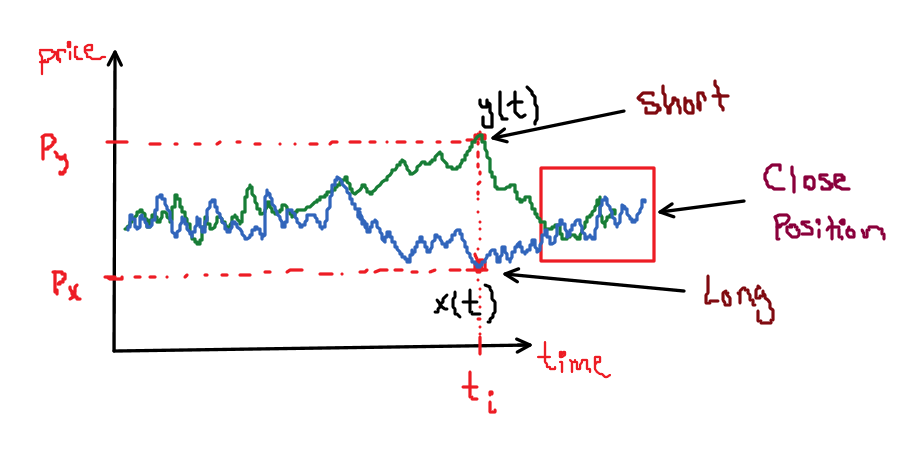

In [1071]:
from IPython.display import Image
Image("diagram(1).png")

Imagine we have the time series for the price of two stocks: X and Y. These two companies are related in some sense. This means they may occupy the same market, depend on each other for supply chain reasons, sell to similar customers, etc. As you would notice at $ t < t_{i} $, $ y(t) $ and $ x(t) $ move together for the most part. However, as can often happen in the stock market, related assets can drift apart. Whether it be due to a new product, bad publicity, or low profit margins, the related stocks will eventually drift apart. This is seen at $ t_{i} $, where stocks $ y(t) $ and $ x(t) $ are furthest apart. In other words, at $ t_{i} $ $ |P_{y}-P_{x}| $ is at its greatest value. Due to the concept of Mean Reversion, we know that the two stocks will eventually revert back to their mean value. Therefore, $ y(t) $ will eventually fall and $ x(t) $ will eventually rise. We can make a bet on this information by going short on $ y(t) $ and going long on $ x(t) $. Once the stocks revert to their mean, at time $ t>t_{i} $, we can close the position to make a profit. 

The benefit of "trading pairs" is that the risk of incurring a loss is lower. If, at time $ t>t_{i} $, $ y(t) $ and $ x(t) $ rise, then the profit of the long position could cover the loss of the short position. Likewise, if at time $ t>t_{i} $, $ y(t) $ and $ x(t) $ fall, then the profit of the short position could cover the loss of the long position. Moreover, pairs trading is resilient to overall market trends. Trades are executed on discrepencies between two related assets. Therefore, market trends would cause both assets to move together. As is described above, this could still result in a profit regardless of whether the market trends upward or downward.   

<b>Please note that this is <u>NOT</u> a risk-free strategy and it <u>IS</u> possible to incurr losses if used. This is soleley an educational project to learn about algorithmic trading and data analysis. </b>

<h2>Get, Clean, and Normalize the Data</h2>

In [1072]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

Using intuition, we can make an educated guess on two stocks that may move together. <b>Tesla</b> and <b>JPMorgan</b> (both publically traded) may move together since JPMorgan may hold positions with blue chip stocks such as Tesla that are in the S&P500 index. In other words, the movement of Tesla's stock impacts the success of JPMorgan, and therefore, its stock. Let us see if they are a good fit!

In [1073]:
# Note: we only want the adjusted close data, ytd
STOCK_A = 'TSLA'
STOCK_B = 'JPM'
raw_data = yf.download(tickers=[STOCK_A, STOCK_B], period='ytd', interval='1d')
raw_data = raw_data.drop(columns=['Close', 'High', 'Low', 'Open', 'Volume'])

# Getting rid of 'TSLA' and 'JPM' as sub-columns under 'Adj Close'... making them separate columns
data = pd.DataFrame()
data[STOCK_A] = raw_data['Adj Close'][STOCK_A]
data[STOCK_B] = raw_data['Adj Close'][STOCK_B]

data

[*********************100%***********************]  2 of 2 completed


,TSLA,JPM
Date,,
2021-01-04,729.770020,123.526443
2021-01-05,735.109985,124.198593
2021-01-06,755.979980,130.030441
2021-01-07,816.039978,134.300537
2021-01-08,880.020020,134.448822
...,...,...
2021-08-03,709.739990,152.889999
2021-08-04,710.919983,151.240005
2021-08-05,714.630005,153.149994


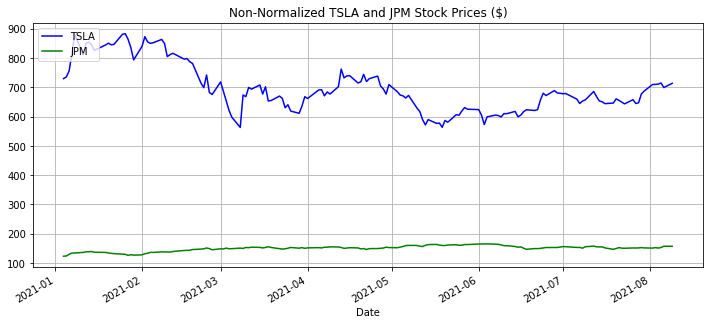

In [1074]:
plt.figure(figsize=(12,5))
axis1 = data[STOCK_A].plot(color='blue', grid=True, label=STOCK_A)
axis2 = data[STOCK_B].plot(color='green', grid=True, label=STOCK_B)
h1, l1 = axis1.get_legend_handles_labels()
h2, l2 = axis2.get_legend_handles_labels()
plt.legend(h1, l1, loc=2)
plt.title(label='Non-Normalized TSLA and JPM Stock Prices ($)')

plt.show()

In [1075]:
# Normalize the the dataframe using cumulative percentage change
norm_data = pd.DataFrame()

norm_data[STOCK_A] = data[STOCK_A].pct_change().cumsum()
norm_data[STOCK_B] = data[STOCK_B].pct_change().cumsum()

# The first row will contain NaN, since there is no previous row to calculate percent change
norm_data = norm_data.tail(len(data) - 1)

norm_data

,TSLA,JPM
Date,,
2021-01-05,0.007317,0.005441
2021-01-06,0.035708,0.052397
2021-01-07,0.115154,0.085236
2021-01-08,0.193557,0.086341
2021-01-11,0.115343,0.101265
...,...,...
2021-08-03,0.066010,0.227719
2021-08-04,0.067672,0.216927
2021-08-05,0.072891,0.229556


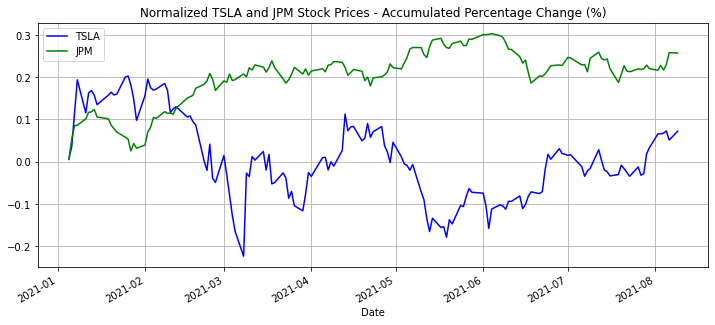

In [1076]:
# Replot the data
plt.figure(figsize=(12,5))
axis1 = norm_data[STOCK_A].plot(color='blue', grid=True, label=STOCK_A)
axis2 = norm_data[STOCK_B].plot(color='green', grid=True, label=STOCK_B)
h1, l1 = axis1.get_legend_handles_labels()
plt.legend(h1, l1, loc=2)
plt.title(label='Normalized TSLA and JPM Stock Prices - Accumulated Percentage Change (%)')

plt.show()

By looking at the percent change in TSLA and JPM stock price, we can better guage the movement of these assets on a single scale.
<b>Visually, it seems like TSLA and JPM move in opposite directions, but somewhat revert back to a constant mean. Let us determine if this is true mathematically.</b>

<h2>Cointegration to Determine a Relationship</h2>

<h3>Plot TSLA against JPM</h3>

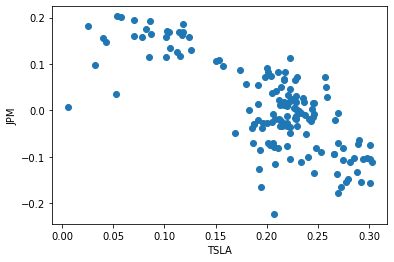

In [1077]:
plt.scatter(norm_data[STOCK_B], norm_data[STOCK_A])
plt.xlabel(STOCK_A)
plt.ylabel(STOCK_B)
plt.show()

It seems that there is some sort of relationship here... as the price of TSLA rises, data points tend to show a lower JPM price.

<h3>We can mathematically test this relationship by testing for cointegration</h3>

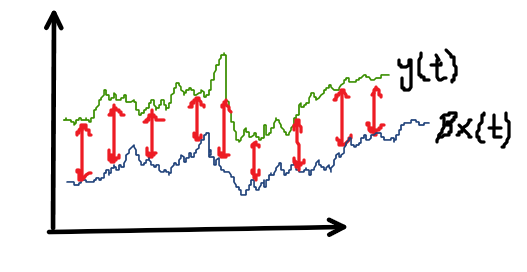

In [1078]:
Image("diagram(2).png")

There exists some $ \beta $ such that $y(t)-\beta x(t)$ is stationary. In other words, the residual, let us call it $\epsilon(t)$, is stationary, and therefore, I(0). For this specific $\beta$ value, we can claim that $y(t)$ and $x(t)$ are <b>cointegrated</b>.

To test for cointegration, we run a least squares regression, giving us the equation $ y(t)= \hat{\beta}x(t) + \hat{\alpha} + \hat{\epsilon}(t)$ where $\hat{\epsilon}(t)$ is the residual and $\hat{\alpha}$ is some constant.

Rearranging, we get the equation $ \hat{\epsilon}(t) = y(t)-\hat{\beta}x(t)-\hat{\alpha} $. As was explained above, if $\hat{\epsilon}(t)$ is stationary - I(0) - then we can claim that $y(t)$ and $x(t)$ are cointegrated, therefore having some sort of meaningful relationship. To determine if $\hat{\epsilon}(t)$ is stationary, we run a Dickey-Fuller (DF) test on the residual. 

In [1079]:
import statsmodels.api as sm

<h3>Least Squares Regression</h3>

In [1080]:
X = sm.add_constant(norm_data[STOCK_A])
Y = norm_data[STOCK_B]
model = sm.OLS(Y, X)
model = model.fit()
alpha = model.params[0]
beta = model.params[1]
print(model.params)
print(model.summary())

const    0.204748
TSLA    -0.521787
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    JPM   R-squared:                       0.571
Model:                            OLS   Adj. R-squared:                  0.568
Method:                 Least Squares   F-statistic:                     197.2
Date:                Mon, 09 Aug 2021   Prob (F-statistic):           5.19e-29
Time:                        18:34:19   Log-Likelihood:                 258.78
No. Observations:                 150   AIC:                            -513.6
Df Residuals:                     148   BIC:                            -507.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c

The Linear Regression Model above gives us a $\hat{\beta} = -0.521539$ and a $\hat{\alpha} = 0.204786$.

We use the linear regression model to calculate the residual, $\hat{\epsilon}(t)$.

In [1081]:
residuals = norm_data[STOCK_B] - (beta * norm_data[STOCK_A]) - alpha
norm_data['Residuals'] = residuals
norm_data

,TSLA,JPM,Residuals
Date,,,
2021-01-05,0.007317,0.005441,-0.195488
2021-01-06,0.035708,0.052397,-0.133719
2021-01-07,0.115154,0.085236,-0.059426
2021-01-08,0.193557,0.086341,-0.017412
2021-01-11,0.115343,0.101265,-0.043299
...,...,...,...
2021-08-03,0.066010,0.227719,0.057414
2021-08-04,0.067672,0.216927,0.047489
2021-08-05,0.072891,0.229556,0.062841


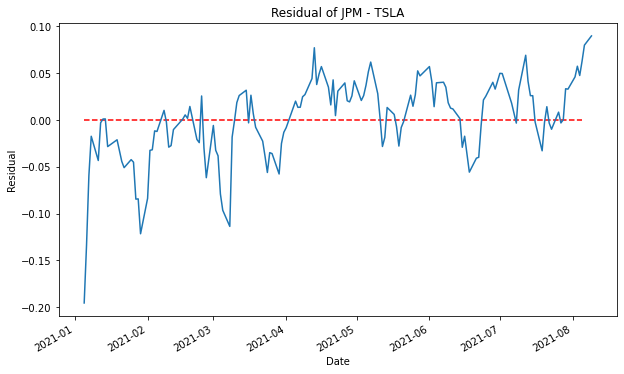

In [1082]:
norm_data['Residuals'].plot(figsize=(10,6))
plt.ylabel('Residual')
plt.title('Residual of JPM - TSLA')
# Dashed line showing the mean of the residual
plt.hlines(y=norm_data['Residuals'].mean(), xmin='2021-01-05', xmax='2021-08-05', colors='red', linestyles='dashed')
plt.show()

<h3>Let us run a DF Test to verify if the residual is in fact stationary</h3>

In [1083]:
from statsmodels.tsa.stattools import adfuller

adf = adfuller(norm_data['Residuals'], maxlag=1)
adf

(-5.009562698148256,
 2.12460802524648e-05,
 0,
 149,
 {'1%': -3.4750180242954167,
  '5%': -2.8811408028842043,
  '10%': -2.577221358046935},
 -701.9764318049902)

ADF Test Statistic: -4.957 < 1%, 5%, and 10% critical values<br>
P-Value = $2.7020 * 10^{-5}$ < 0.05 <br>
<b>We can say with statistical significance that the residual is stationary, and therefore, TSLA and JPM are cointegrated with more than 99% certainty.</b><br><br>
<b>Moreover, as we can see from the least squares regression that was applied above, the correlation $(r^2)$ between TSLA and JPM is 0.570 - a negative (negative $\hat{\beta}$) moderate correlation.</b>

<h2>Determine When To Trade, Simulate Trading</h2>

We have proven mathematically that there is a statistical relationship between TSLA and JPM, one that is mean reverting and stationary. Moreover, we know that TSLA and JPM are negative correlated. Therefore, there are many opportunities to short/long TSLA/JPM and then close the position as it reverts to the mean. <b>Let us now determine when exactly to make these trades.</b>

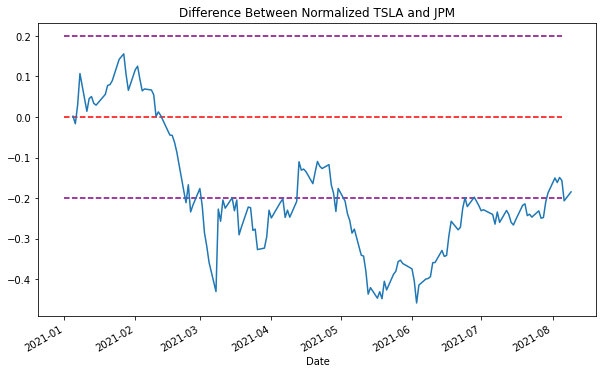

In [1084]:
norm_data['Difference'] = norm_data[STOCK_A] - norm_data[STOCK_B]
norm_data['Difference'].plot(figsize=(10,6))
plt.title('Difference Between Normalized TSLA and JPM')
plt.hlines(y=0, xmin='2021-01-01', xmax='2021-08-05', colors='red', linestyles='dashed')
plt.hlines(y=0.2, xmin='2021-01-01', xmax='2021-08-05', colors='purple', linestyles='dashed')
plt.hlines(y=-0.2, xmin='2021-01-01', xmax='2021-08-05', colors='purple', linestyles='dashed')

plt.show()

<h3>The ideal time to close a position would be when the difference between TSLA and JPM is 0. In other words, both assets have reverted back to the mean value. That being said, we can establish a range in which we can close the position, thus allowing us to execute trades more conservatively if desired. </h3>

As can be seen above, the close-range is when <b>-0.2 < difference < 0.2</b> <br><br>
<b>To find ideal trading points, we simply check the position of the daily difference with respect to the close-range</b>. If we are in the close range, we close our current position if one exists. As we move outside the close-range, we open a new short/long position, the specifics of which depends on whether we have moved above or below the close-range.<br><br>
<b>We can use lagged data points to determine whether to open a new position or not</b>. For example, if the |difference| has been inreasing for many days, then the signal to short/long JPM/TSLA would be strong. This is because our stocks are mean reverting, meaning that as the difference rises (and so does the spread of the two stocks), the probability that they will both revert back into the close-range increases. Likewise, if the |difference| has only been increasing for one day, then this is likely NOT a reversion back to the mean. Rather, it IS likely the beginning of movement away from the mean.<br><br>
<b>Based on how many consecutive days the movement of the difference has continued in the same direction, we can create a weak/strong buy signal</b>. If the strength crosses some pre-determined threshold, then we can safely execute a buy. The sell signal will come once we revert back into the close-range. The larger the number of consecutive days we are in the close-range, the stronger the sell signal becomes. <br><br>
We also track the total money spent during the trading simulation. For a long position, the money spent is simply the price of the longed stock when the position is created. For a short stock, we assume a <b>simple margin account</b> that only charges a 5% fee on the value of the borrowed stock when it is sold. <br><br>
The position structure of this simulation is quite simple. We are only allowed to have <b>one position at any given time</b>. While this does limit the profit to be made - there are multiple peaks at which a position can be created - it creates a safer and more conservative trading model. Moreover, this one position consists of <b>one shorted stock and one longed stock</b>.  

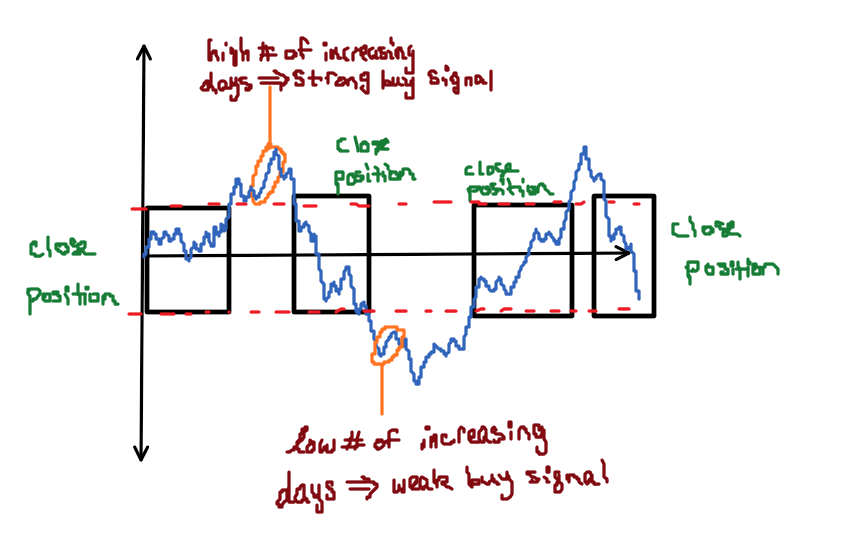

In [1085]:
Image("diagram(3).png")

In [1086]:
norm_data.reset_index(inplace=True)
norm_data

,Date,TSLA,JPM,Residuals,Difference
0,2021-01-05,0.007317,0.005441,-0.195488,0.001876
1,2021-01-06,0.035708,0.052397,-0.133719,-0.016690
2,2021-01-07,0.115154,0.085236,-0.059426,0.029918
3,2021-01-08,0.193557,0.086341,-0.017412,0.107217
4,2021-01-11,0.115343,0.101265,-0.043299,0.014078
...,...,...,...,...,...
145,2021-08-03,0.066010,0.227719,0.057414,-0.161709
146,2021-08-04,0.067672,0.216927,0.047489,-0.149255
147,2021-08-05,0.072891,0.229556,0.062841,-0.156665
148,2021-08-06,0.051159,0.257959,0.079905,-0.206800


In [1087]:
def print_position(position):
    print('Short Stock: ' + position['short_stock'])
    print('\t' + 'Borrowed & Sold: $' + str(position['short_value_orig']))
    print('\t' + 'Current Buy Price: $' + str(position['short_value_curr']))
    print('Long Stock: ' + position['long_stock'])
    print('\t' + 'Bought: $' + str(position['long_value_orig']))
    print('\t' + 'Current Sell Price: $' + str(position['long_value_curr']))
    print('Total Profit: $' + str(position['total_profit']))
    print('Realized Profit: $' + str(position['realized_profit']))
    print('Total Money Spent: $' + str(position['total_money_spent']))

In [1088]:
# Create a new dataframe to store the results of each day in the trading simulation
df_columns = ['Date', 'Buy or Sell', 'Signal', 'Signal Strength', 'Decision', 'Short Stock', 'Borrowed & Sold', 'Current Buy Price', 'Long Stock', 'Bought', 'Current Sell Price', 'Total Profit', 'Realized Profit', 'Total Money Spent']
trading_sim = pd.DataFrame(columns=df_columns)
trading_sim['Date'] = norm_data['Date']

trading_sim

,Date,Buy or Sell,Signal,Signal Strength,Decision,Short Stock,Borrowed & Sold,Current Buy Price,Long Stock,Bought,Current Sell Price,Total Profit,Realized Profit,Total Money Spent
0,2021-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,2021-08-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
146,2021-08-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
147,2021-08-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
148,2021-08-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1092]:
position_exists = False
num_inc_days = 0
num_dec_days = 0
num_days_in_close_range = 0

# Assume that on a short position, we have to pay a 5% fee of the stock's price when it is borrowed
position = {
    'short_stock': '',
    'short_value_orig': 0,
    'short_value_curr': 0,
    'long_stock': '',
    'long_value_orig': 0,
    'long_value_curr': 0,
    'total_profit': 0,
    'realized_profit': 0,
    'total_money_spent': 0
}

SIGNAL_THRESHOLD = (5/7) #The minimum requirement for a strong buy/sell signal is 5 days of consecutive movement

# Let us say 7 days is the measure of a 100% strength buy signal
# In other words, if the stock moves in the same direction for a week, we can safely assume we are at a local minimum
ONE_WEEK = 7

for i in range(len(norm_data)):

    if (position_exists):
        # Update the value of stocks - and our total profit - in our position each day
        position['short_value_curr'] = data.iloc[i][position['short_stock']]
        position['long_value_curr'] = data.iloc[i][position['long_stock']]
        short_profit = position['short_value_orig'] - position['short_value_curr']
        long_profit = position['long_value_curr'] - position['long_value_orig']
        position['total_profit'] = short_profit + long_profit + position['realized_profit']

    print(norm_data.iloc[i]['Date'])

    # Once the end of the trading term is reached, close out whatever position is currently held
    if (position_exists and i == (len(norm_data) - 1)):
            print('End of trading term reached... close out position')
            print('SELL Signal: ' + str(num_days_in_close_range/ONE_WEEK))
            print('CLOSE POSITION')
            short_profit = position['short_value_orig'] - position['short_value_curr']
            long_profit = position['long_value_curr'] - position['long_value_orig']
            position['realized_profit'] += short_profit + long_profit
            position_exists = False

    # We are in the close-range
    if (abs(norm_data.iloc[i]['Difference']) < 0.2):
        num_days_in_close_range += 1

        # Update 'Buy or Sell' & 'Signal in trading sim
        trading_sim.at[i, 'Buy or Sell'] = 'Sell'
        trading_sim.at[i, 'Signal'] = num_days_in_close_range / ONE_WEEK

        # Strong Sell Signal, Close the Position
        if (position_exists and (num_days_in_close_range / ONE_WEEK) >= SIGNAL_THRESHOLD):
            trading_sim.at[i, 'Signal Strength'] = 'Strong'
            trading_sim.at[i, 'Decision'] = 'Close Position'

            print('SELL Signal: ' + str(num_days_in_close_range/ONE_WEEK))
            print('CLOSE POSITION')
            short_profit = position['short_value_orig'] - position['short_value_curr']
            long_profit = position['long_value_curr'] - position['long_value_orig']
            position['realized_profit'] += short_profit + long_profit
            position_exists = False

        # Weak Sell Signal, DO NOT close the position
        elif (position_exists and (num_days_in_close_range / ONE_WEEK) < SIGNAL_THRESHOLD):
            trading_sim.at[i, 'Signal Strength'] = 'Weak'
            trading_sim.at[i, 'Decision'] = 'Maintain Position'

            print('SELL Signal: ' + str(num_days_in_close_range/ONE_WEEK))
            print('In close-range, but weak sell signal... Maintain Position')

        # We do not currently hold a position, do nothing
        elif (not(position_exists)):
            trading_sim.at[i, 'Decision'] = 'NO POSITION'

            print('SELL Signal: ' + str(num_days_in_close_range/ONE_WEEK))
            print('No currently held position, cannot open a new position in the close-range')
    
    # We are OUTSIDE the close-range
    else:
        num_days_in_close_range = 0

        # Compare today's difference to yesterday, determine direction and change number of inc/dec days
        if (norm_data.iloc[i]['Difference'] > norm_data.iloc[i - 1]['Difference']):
            num_inc_days += 1
            num_dec_days = 0
        elif (norm_data.iloc[i]['Difference'] < norm_data.iloc[i - 1]['Difference']):
            num_dec_days += 1
            num_inc_days = 0

        # Update 'Buy or Sell' & 'Signal in trading sim
        trading_sim.at[i, 'Buy or Sell'] = 'Buy'
        trading_sim.at[i, 'Signal'] = num_days_in_close_range / ONE_WEEK

        # We cannot open a new position if we already have a position
        if (position_exists):
            trading_sim.at[i, 'Decision'] = 'ALREADY POSITIONED'

            print('BUY Signal: ' + str(num_inc_days/ONE_WEEK))
            print('Position has already been opened.')

        # We are ABOVE the close-range
        elif (norm_data.iloc[i]['Difference'] > 0.2):
            print('BUY Signal: ' + str(num_inc_days/ONE_WEEK))

            # Strong buy signal, short A and long B, get their current values, calculate money spent
            if ((num_inc_days/ONE_WEEK) >= SIGNAL_THRESHOLD):
                trading_sim.at[i, 'Signal Strength'] = 'Strong'
                trading_sim.at[i, 'Decision'] = 'Open Position'

                print('STRONG BUY SIGNAL')
                position['short_stock'] = STOCK_A
                position['short_value_orig'] = data.iloc[i][STOCK_A]
                position['short_value_curr'] = data.iloc[i][STOCK_A]
                position['long_stock'] = STOCK_B
                position['long_value_orig'] = data.iloc[i][STOCK_B]
                position['long_value_curr'] = data.iloc[i][STOCK_B]
                position_exists = True
                position['total_money_spent'] = position['long_value_orig'] + (position['short_value_orig'] * 0.05)

            else:
                trading_sim.at[i, 'Signal Strength'] = 'Weak'
                trading_sim.at[i, 'Decision'] = 'No New Position'

                print('Weak Buy Signal... do not open a new position')
        
        # We are BELOW the close-range
        elif (norm_data.iloc[i]['Difference'] < -0.2):
            print('BUY Signal: ' + str(num_dec_days/ONE_WEEK))

            # Strong buy signal, short B and long A, get their current values, calculate money spent
            if ((num_dec_days/ONE_WEEK) >= SIGNAL_THRESHOLD):
                trading_sim.at[i, 'Signal Strength'] = 'Strong'
                trading_sim.at[i, 'Decision'] = 'Open Position'

                print('STRONG BUY SIGNAL')
                position['short_stock'] = STOCK_B
                position['short_value_orig'] = data.iloc[i][STOCK_B]
                position['short_value_curr'] = data.iloc[i][STOCK_B]
                position['long_stock'] = STOCK_A
                position['long_value_orig'] = data.iloc[i][STOCK_A]
                position['long_value_curr'] = data.iloc[i][STOCK_A]
                position_exists = True
                position['total_money_spent'] = position['long_value_orig'] + (position['short_value_orig'] * 0.05)
            else:
                trading_sim.at[i, 'Signal Strength'] = 'Weak'
                trading_sim.at[i, 'Decision'] = 'No New Position'

                print('Weak Buy Signal... do not open a new position')
    print_position(position)

    trading_sim.at[i, 'Short Stock'] = position['short_stock']
    trading_sim.at[i, 'Borrowed & Sold'] = position['short_value_orig']
    trading_sim.at[i, 'Current Buy Price'] = position['short_value_curr']
    trading_sim.at[i, 'Long Stock'] = position['long_stock']
    trading_sim.at[i, 'Bought'] = position['long_value_orig']
    trading_sim.at[i, 'Current Sell Price'] = position['long_value_curr']
    trading_sim.at[i, 'Total Profit'] = position['total_profit']
    trading_sim.at[i, 'Realized Profit'] = position['realized_profit']
    trading_sim.at[i, 'Total Money Spent'] = position['total_money_spent']
        
    print('----------------------------------------------------------------------')

2021-01-05 00:00:00
SELL Signal: 0.14285714285714285
No currently held position, cannot open a new position in the close-range
Short Stock: 
	Borrowed & Sold: $0
	Current Buy Price: $0
Long Stock: 
	Bought: $0
	Current Sell Price: $0
Total Profit: $0
Realized Profit: $0
Total Money Spent: $0
----------------------------------------------------------------------
2021-01-06 00:00:00
SELL Signal: 0.2857142857142857
No currently held position, cannot open a new position in the close-range
Short Stock: 
	Borrowed & Sold: $0
	Current Buy Price: $0
Long Stock: 
	Bought: $0
	Current Sell Price: $0
Total Profit: $0
Realized Profit: $0
Total Money Spent: $0
----------------------------------------------------------------------
2021-01-07 00:00:00
SELL Signal: 0.42857142857142855
No currently held position, cannot open a new position in the close-range
Short Stock: 
	Borrowed & Sold: $0
	Current Buy Price: $0
Long Stock: 
	Bought: $0
	Current Sell Price: $0
Total Profit: $0
Realized Profit: $0
To

<h2>Write Trading Results to a CSV</h2>

In [1096]:
trading_sim.to_csv('./trading_simulation.csv', index=False)

trading_sim

,Date,Buy or Sell,Signal,Signal Strength,Decision,Short Stock,Borrowed & Sold,Current Buy Price,Long Stock,Bought,Current Sell Price,Total Profit,Realized Profit,Total Money Spent
0,2021-01-05,Sell,0.142857,NaN,NO POSITION,,0,0,,0,0,0,0,0
1,2021-01-06,Sell,0.285714,NaN,NO POSITION,,0,0,,0,0,0,0,0
2,2021-01-07,Sell,0.428571,NaN,NO POSITION,,0,0,,0,0,0,0,0
3,2021-01-08,Sell,0.571429,NaN,NO POSITION,,0,0,,0,0,0,0,0
4,2021-01-11,Sell,0.714286,NaN,NO POSITION,,0,0,,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,2021-08-03,Sell,0.428571,Weak,Maintain Position,JPM,156.617477,151.169998,TSLA,670.940002,709.669983,182.752625,138.575165,678.770876
146,2021-08-04,Sell,0.571429,Weak,Maintain Position,JPM,156.617477,152.889999,TSLA,670.940002,709.73999,181.102631,138.575165,678.770876
147,2021-08-05,Sell,0.714286,Strong,Close Position,JPM,156.617477,151.240005,TSLA,670.940002,710.919983,183.932617,183.932617,678.770876
148,2021-08-06,Buy,0.0,Weak,No New Position,JPM,156.617477,151.240005,TSLA,670.940002,710.919983,183.932617,183.932617,678.770876


<h2>Final Position Details</h2>

In [1090]:
print_position(position)
print('Profit is ' + str(round(position['total_profit'] / position['total_money_spent'] * 100, 2)) + '% of money spent')

Short Stock: JPM
	Borrowed & Sold: $156.6174774169922
	Current Buy Price: $151.24000549316406
Long Stock: TSLA
	Bought: $670.9400024414062
	Current Sell Price: $710.9199829101562
Total Profit: $183.9326171875
Realized Profit: $183.9326171875
Total Money Spent: $678.7708763122558
Profit is 27.1% of money spent


<h2>By the end of the trading term (8/9/2021) we have reached a profit of $183.93, which is 27.1% of our money invested. Keep in mind that when we created new positions, we simply shorted/longed ONE stock of JPM and TSLA. If we shorted/longed MULTIPLE stocks of JPM and TSLA, our profit percentage would remain the same but the NOMINAL AMOUNT WOULD INCREASE.</h2>